# Создаем свой набор данных из Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

Эта тетрадка показывает, как сделать свой набор данных из Google Images.

In [1]:
from fastai.vision import *

## Получаем список URL

### Ищем

Переходи в [Google Images](http://images.google.com) и найди какие-нибудь картинки. Чем точнее будет запрос, тем меньше времени в дальнейшем понадобится на ручную чистку данных.

Прокрути вниз, чтобы прогрузить все нужные картинки. Теперь они доступны для скачивания.

__Подсказка:__ можно исключать часть результатов с помощью `-`, например: `surfing -board`. Так же можно отфильтровать только изображения с помощью кнопки "Инструменты".

### Сохраняем в файл

На этом шаге тебе придется немного покопаться в Javascript: запустить мой сниппет, который найдет на страничке все ссылки на оригиналы картинок.

Нажми <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>J</kbd> на Windows/Linux или <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>J</kbd> на Mac, появится консоль Javascript. Сюда нужно скопировать этот код, который создаст список ссылок:

```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
s = urls.join('\n')
```

Скопируй этот список и сохрани в файл `<class_name>_urls.csv`

### Создай директорию с данными загрузи свои текстовые файлы

In [2]:
# Choose an appropriate name for your labeled images
path = Path('data/water_sports')
# Change this for your set of class names
classes = ['surfing', 'bodyboarding', 'wakeboarding']

for c in classes:
    dest = path/c
    dest.mkdir(parents=True, exist_ok=True)

In [3]:
path.ls()

[PosixPath('data/water_sports/surfing'),
 PosixPath('data/water_sports/bodyboarding'),
 PosixPath('data/water_sports/wakeboarding')]

Теперь загрузи созданные файлы в эту директорию через Юпитер.

## Download images

Воспользуйся функцией из fastai, чтобы скачать картинки:

In [4]:
for c in classes:
    print(c)
    # If you have problems download, try with `max_workers=0` to see exceptions
    download_images(path / f'{c}_urls.csv', path/c)

Теперь удали картинки, которые не открываются:

In [5]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View data

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [7]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Let's take a look at some of our pictures then.

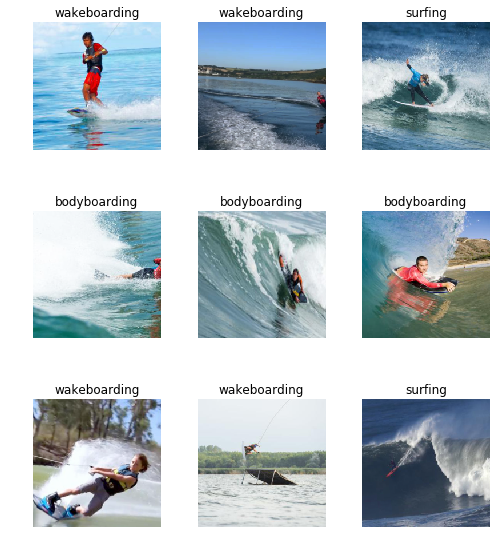

In [9]:
data.show_batch(rows=3, figsize=(7,8))

In [10]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['bodyboarding', 'surfing', 'wakeboarding'], 3, 784, 196)

## Train model

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.128584,0.671104,0.316327,00:08
1,0.838202,0.558760,0.229592,00:05
2,0.713776,0.543853,0.244898,00:05
3,0.642328,0.530944,0.219388,00:05


In [13]:
learn.save('stage-1')

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


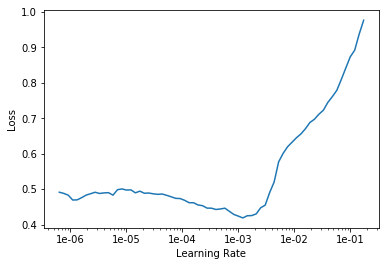

In [16]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.509595,0.499467,0.204082,00:07
1,0.479009,0.467526,0.209184,00:07
2,0.418468,0.462277,0.204082,00:07
3,0.399064,0.452537,0.183673,00:07


In [18]:
learn.save('stage-2')

## Interpretation

In [19]:
learn.load('stage-2');

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

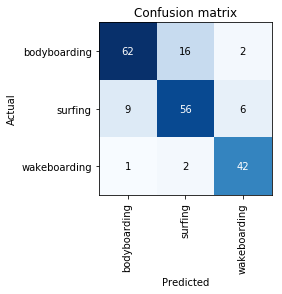

In [21]:
interp.plot_confusion_matrix()

In [32]:
interp.most_confused()

[('bodyboarding', 'surfing', 16),
 ('surfing', 'bodyboarding', 9),
 ('surfing', 'wakeboarding', 6),
 ('bodyboarding', 'wakeboarding', 2),
 ('wakeboarding', 'surfing', 2),
 ('wakeboarding', 'bodyboarding', 1)]

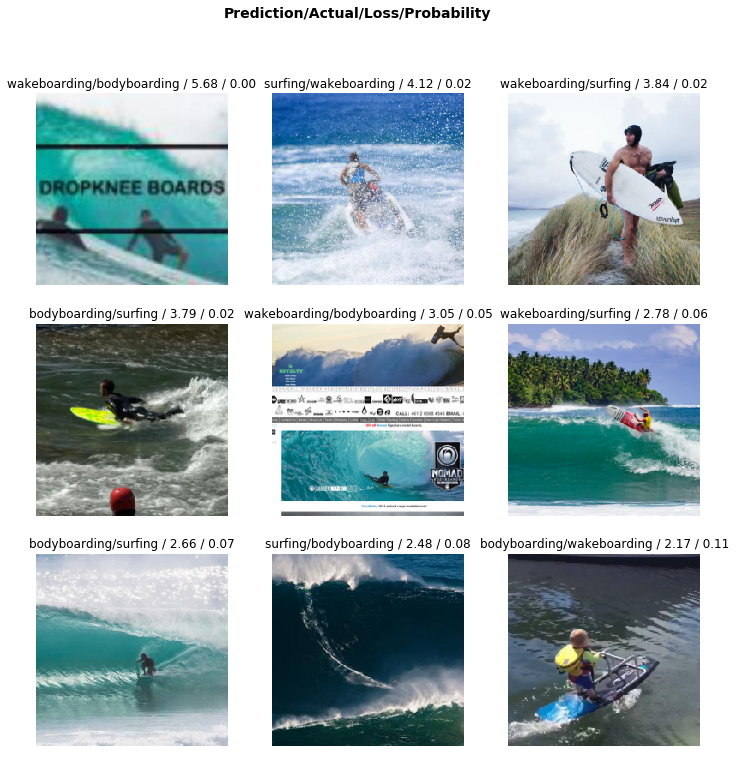

In [39]:
interp.plot_top_losses(9)

## Чистим датасет

Некоторые из ошибок произошли не по вине модели, а из-за "грязных" данных (категория не соответствует действительности). 

Используй `ImageCleaner` widget из `fastai.widgets`, чтобы удалить "грязные" данные или изменить категории.

In [22]:
from fastai.widgets import *

Создаем новый датасет без разбиения на train/valid.

In [23]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [24]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .no_split()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )

Then we create a new learner to use our new databunch with all the images.

In [25]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
# First we need to get the file paths from our top_losses. 
# We can do this with `.from_toplosses`. 
# We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Виджет не удаляет картинки с диска, а только создает новый файл `cleaned.csv`, в который записываются верные категории.

`ImageCleaner` на данный момент работает только в Jupyter Notebook (НЕ Lab).

In [45]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())


If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this [link](https://github.com/fastai/fastai/issues/1539#issuecomment-505999861) to solve it.


Таким же способом можно удалять дубликаты:

In [46]:
# Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. 
# Otherwise the file would be overwritten from scratch, 
# losing all the results from cleaning the data from toplosses.

db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   .no_split()
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [47]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

In [48]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [49]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [50]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.228019,0.655483,0.276923,00:06
1,0.963230,0.551505,0.189744,00:05
2,0.777788,0.515319,0.179487,00:05
3,0.681972,0.504041,0.174359,00:05


In [51]:
learn.save('cleaned-1')

In [52]:
learn.unfreeze()

In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


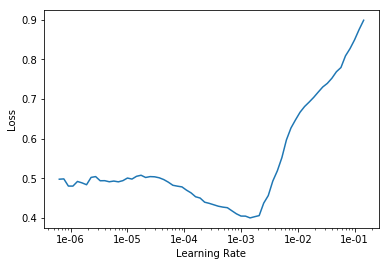

In [54]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(4, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.514964,0.547167,0.189744,00:07
1,0.466157,0.552372,0.184615,00:07
2,0.366381,0.493014,0.179487,00:07
3,0.309165,0.478457,0.158974,00:07


In [56]:
learn.save('cleaned-2')

## Публикуем модель

В fastai все очень просто: экспортируем `Learner`.

In [63]:
learn.export()

В рабочей директории создается файл `export.pkl`, котрый содержит модель, веса и метаданные (метки классов, виды трансформаций/нормализации применяемых к изображениям).

Для этой задачи достаточно процессора, т.к. мы уже не обучаем сеть, а только лишь делаем inference.

In [64]:
defaults.device = torch.device('cpu')

Открываем свою картинку (которую сеть не видела):

In [ ]:
img = open_image('data/water_sports/me.png')
img

In [69]:
# We create our `Learner` in production enviromnent like this, 
# just make sure that `path` contains the file 'export.pkl' from before.
learn = load_learner(path)

In [70]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category surfing

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [71]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [72]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,16.085201,3183550.750000,0.712821,00:06


### Learning rate (LR) too low

In [73]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [74]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,1.474059,1.174827,0.661538,00:05
1,1.431402,1.176183,0.651282,00:05
2,1.450721,1.170934,0.646154,00:05
3,1.433290,1.169508,0.651282,00:05
4,1.436600,1.172756,0.646154,00:05


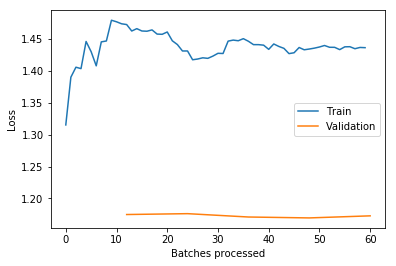

In [75]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [76]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, pretrained=False)

In [77]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.346050,1.113228,0.635897,00:07


### Too many epochs

In [78]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [79]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [80]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.548005,1.810486,0.909400,00:12
1,1.544579,1.696906,0.881087,00:06
2,1.533163,1.598918,0.841450,00:06
3,1.483822,1.519798,0.778029,00:06
4,1.444955,1.447925,0.728199,00:06
5,1.409384,1.372467,0.651189,00:06
6,1.331345,1.302227,0.583239,00:06
7,1.257292,1.234432,0.545866,00:06
8,1.172821,1.176153,0.510759,00:06
9,1.094959,1.130037,0.488109,00:06


KeyboardInterrupt: 